#### MNIST 글씨 분류
- 사용 데이터 : mnist_train.csv, mnist_test.csv
- 피처/속성 : 
- 타겟/라벨 : 마지막 열
- 학습-방법 : 지도학습 > 분류> 다중분류
- 학습 알고리즘 : 인공신경망(ANN) -> 심층 신경망 (MLP, DNN) : 은닉층이 많은 구성
- 프레임워크 : Pytorch

In [1]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torchmetrics.classification import MulticlassF1Score
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as scheduler

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
train_data = '../data/mnist_train.csv'
test_data = '../data/mnist_test.csv'
train_df = pd.read_csv(train_data, header=None)
test_df = pd.read_csv(test_data, header= None)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


In [4]:
test_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
class letterModel(nn.Module):
    def __init__(self, inout=5, perceptrons=[]) :
        super().__init__()
        self.i_layer = nn.Linear(784, perceptrons[0] if len(perceptrons)>0 else inout)

        self.h_layers = nn.ModuleList()
        for idx in range(len(perceptrons)-1):
            self.h_layers.append(nn.Linear(perceptrons[idx], perceptrons[idx+1]))
        
        self.o_layer = nn.Linear(perceptrons[-1] if len(perceptrons)>1 else inout, 10)

    def forward(self, x):
        y = F.leaky_relu(self.i_layer(x))

        for layer in self.h_layers:
            y = F.leaky_relu(layer(y))
        
        return(self.o_layer(y))

In [6]:
model = letterModel(perceptrons=[1024,256,64,16])
print(model)

letterModel(
  (i_layer): Linear(in_features=784, out_features=1024, bias=True)
  (h_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=16, bias=True)
  )
  (o_layer): Linear(in_features=16, out_features=10, bias=True)
)


In [7]:
class letterDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values)

        return featureTS, targetTS

In [8]:
featureDF = train_df[train_df.columns[:-1]]
targetDF = train_df[train_df.columns[-1:]]

letterDS = letterDataset(featureDF, targetDF)

letterDL = DataLoader(letterDS)

In [9]:
EPOCH = 100
BATCH_SIZE = 32
LR = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
model = model.to(DEVICE)

In [11]:
X_train = featureDF
X_test = test_df[test_df.columns[:-1]]
y_train = targetDF
y_test = test_df[test_df.columns[-1:]]

print(f'{X_train.shape} {X_test.shape}')
print(f'{y_train.shape} {y_test.shape}')

# 학습/검증/테스트용 데이터셋 생성
trainDS = letterDataset(X_train, y_train)
testDS = letterDataset(X_test, y_test)

# 학습용 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE)

(60000, 784) (10000, 784)
(60000, 1) (10000, 1)


In [15]:
# 파라미터 확인
for named, param in model.named_parameters():
    print(f'[{named}] - {param.shape}')

[i_layer.weight] - torch.Size([1024, 784])
[i_layer.bias] - torch.Size([1024])
[h_layers.0.weight] - torch.Size([256, 1024])
[h_layers.0.bias] - torch.Size([256])
[h_layers.1.weight] - torch.Size([64, 256])
[h_layers.1.bias] - torch.Size([64])
[h_layers.2.weight] - torch.Size([16, 64])
[h_layers.2.bias] - torch.Size([16])
[o_layer.weight] - torch.Size([10, 16])
[o_layer.bias] - torch.Size([10])


In [13]:
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=8, verbose=True)
crossLoss = nn.CrossEntropyLoss()

c:\Users\kdp\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
loss_history, score_history = [[],[]],[[],[]]
cnt = letterDS.n_rows/BATCH_SIZE

for epoch in range(EPOCH):
    model.train

    total_loss, total_score = 0,0

    for featureTS, targetTS in trainDL:
        pre_y = model(featureTS)

        loss = crossLoss(pre_y, targetTS.reshape(-1).long())
        total_loss += loss.item()

        score = MulticlassF1Score(num_classes=10)(pre_y, targetTS.reshape(-1))
        total_score += score.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        test_featureTS = torch.FloatTensor(testDS.featureDF.values)
        test_targetTS = torch.FloatTensor(testDS.targetDF.values)

        pre_test = model(test_featureTS)

        loss_test = crossLoss(pre_test, test_targetTS.reshape(-1).long())

        score_test = MulticlassF1Score(num_classes=10)(pre_test, test_targetTS.reshape(-1))
    
    loss_history[0].append(total_loss/cnt)
    score_history[0].append(total_score/cnt)

    loss_history[1].append(loss_test)
    score_history[1].append(score_test)

    print(f'[{epoch+1}/{EPOCH}]\n- [TRAIN] LOSS : {loss_history[0][-1]} SCORE : {score_history[0][-1]}')
    print(f'- [TEST] LOSS : {loss_history[1][-1]} SCORE : {score_history[1][-1]}')
    
    scheduler.step(score_test)
    print(f'scheduler.num_bad_epochs => {scheduler.num_bad_epochs}')

    if scheduler.num_bad_epochs >= scheduler.patience :
        print(f'성능 개선이 없어서 {scheduler.patience} EPOCH에 조기 종료함!')
        break        


KeyboardInterrupt: 

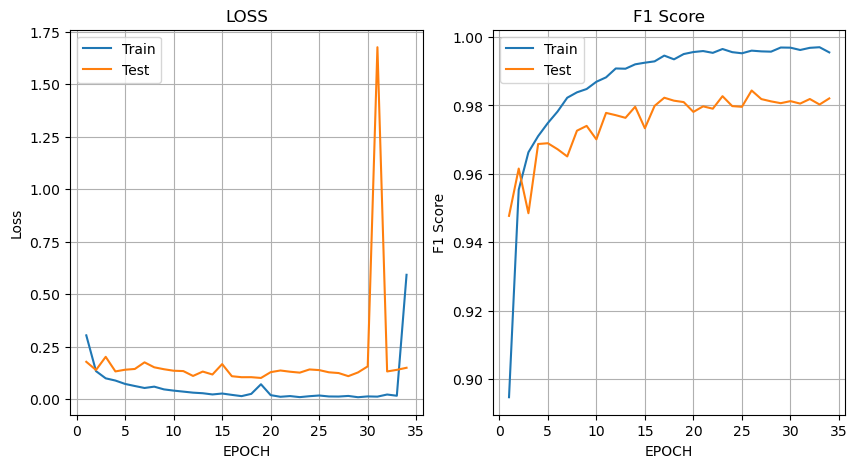

In [16]:
# 시각화
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True)

ax[0].plot(range(1,len(loss_history[0])+1), loss_history[0], label = 'Train')
ax[0].plot(range(1,len(loss_history[0])+1), loss_history[1], label = 'Test')
ax[0].grid('--')
ax[0].legend()
ax[0].set_xlabel('EPOCH')
ax[0].set_ylabel('Loss')
ax[0].set_title('LOSS')

ax[1].plot(range(1,len(loss_history[0])+1), score_history[0], label = 'Train')
ax[1].plot(range(1,len(loss_history[0])+1), score_history[1], label = 'Test')
ax[1].grid('--')
ax[1].legend()
ax[1].set_xlabel('EPOCH')
ax[1].set_ylabel('F1 Score')
ax[1].set_title('F1 Score')

plt.show()

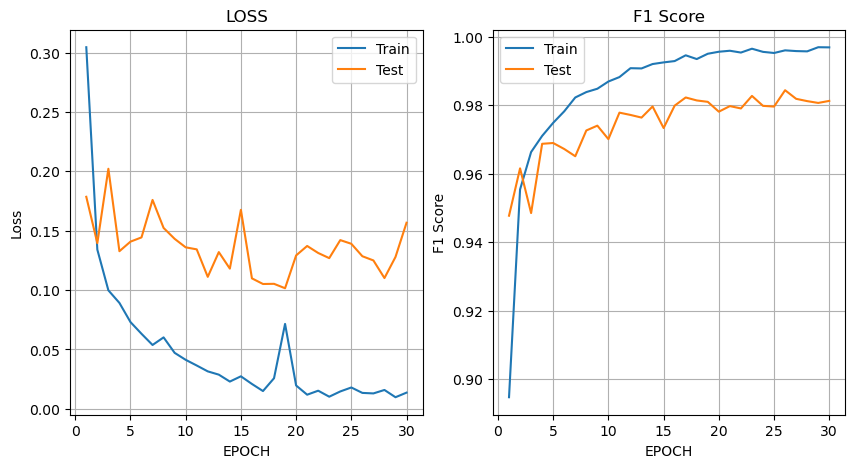

In [20]:
# 2차 시각화
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True)

ax[0].plot(range(1,31), loss_history[0][:30], label = 'Train')
ax[0].plot(range(1,31), loss_history[1][:30], label = 'Test')
ax[0].grid('--')
ax[0].legend()
ax[0].set_xlabel('EPOCH')
ax[0].set_ylabel('Loss')
ax[0].set_title('LOSS')

ax[1].plot(range(1,31), score_history[0][:30], label = 'Train')
ax[1].plot(range(1,31), score_history[1][:30], label = 'Test')
ax[1].grid('--')
ax[1].legend()
ax[1].set_xlabel('EPOCH')
ax[1].set_ylabel('F1 Score')
ax[1].set_title('F1 Score')

plt.show()